# Lab 5: Using logistic regression to predict the quality of mass spectrometry experiments.

As we learned in the previous lecture, logistic regression is a supervised learning method for classification when you have two classes. In this lab, we're going to explore one use case of logistic regression applied to mass spectrometry data: predicting the quality of an LC-MS experiment. In fact, we'll actually be recreating some of the work presented by [Amidan et al](https://pubs.acs.org/doi/10.1021/pr401143e).

Before we begin our analysis though, we need to first import a few Python packages:

In [1]:
import pandas as pd                # For working with tabular data.
import matplotlib.pyplot as plt    # For plotting data
import seaborn as sns              # For theming our plots.
from sklearn.linear_model import (
    LogisticRegression,            # To use logistic regression.
    LogisticRegressionCV,          # Automatically select hyperparameters using cross-validation
) 
from sklearn.preprocessing import StandardScaler # Used to normalize the features

# These will calculate our ROC and precision-recall curve metrics.
from sklearn.metrics import (
    roc_auc_score,
    RocCurveDisplay,
    average_precision_score,
    PrecisionRecallDisplay,
)

# Make our plots look nice:
sns.set(context="notebook", style="ticks")

# These variables define the paths to our data:
metadata_csv = "../data/quality/metadata.csv"  # A summary of the data
train_csv = "../data/quality/training.csv"     # The training set
test_csv = "../data/quality/test.csv"          # The test set


## The data

The data that we'll be working with was manually annotated to label LC-MS datasets on several Orbitrap instruments as either good or poor. Here is how [Amidan et al](https://pubs.acs.org/doi/10.1021/pr401143e) describe the annotation process:
> The data sets were manually reviewed by three expert instrument operators (30+ years of combined LC–MS experience) using an in-house graphical user interface viewer. This viewer contained the base peak chromatogram, total ion current chromatogram, plots of both the top 50 000 and top 500 000 LC–MS detected features, and the number of peptides identified. In the first round, 1150 data sets were manually curated as “good”, “okay”, or “poor” and used to develop the classifier. In cases where the assessors disagreed (∼5–10%), the majority opinion was taken for the curated value. Moreover, the “okay” value was used to denote the wide range of performance, which, although not optimal, was still acceptable. 

This annoation process resulted in the following data thate we'll be using. Run the code cell below to see an overview:

In [2]:
# Read and display the metadata table:
pd.read_csv(metadata_csv)

,instrument,number of good/OK datasets,number of poor data sets,total,number of noncurated data sets
0,Exactive,66,19,85,225
1,LTQ IonTrap,123,101,224,243
2,LTQ Orbitrap,257,123,380,461
3,Velos Orbitrap,339,122,461,1321
4,total,785,365,1150,2250


Four our model, we're going to focus on the Velo Orbitrap data, because that has the most examples. We must model them each individually, because they have different features. Let's load the training data and take a look:

In [3]:
train_df = pd.read_csv(train_csv) # Read the training data.
train_df

,Instrument_Category,Instrument,Dataset_ID,Acq_Time_Start,Acq_Length,Dataset,Dataset_Type,Curated_Quality,XIC_WideFrac,XIC_FWHM_Q1,...,MS2_4D,P_1A,P_1B,P_2A,P_2B,P_2C,P_3,P_2Anorm,BinomResp,LLRC.Prediction
0,Exactive,Exact01,263932,3/20/12,59,QC_Shew_11_06_Run-01_20Mar12_Roc_12-02-40,HMS,poor,0.000000,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.87
1,Exactive,Exact01,263934,3/22/12,59,QC_Shew_11_06_Run-01_22Mar12_Roc_12-02-40,HMS,good,0.000000,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.01
2,Exactive,Exact01,263937,3/20/12,59,QC_Shew_11_06_Run-03_20Mar12_Roc_12-02-42,HMS,poor,0.000000,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.00
3,Exactive,Exact01,263938,3/21/12,59,QC_Shew_11_06_Run-03_21Mar12_Roc_12-02-42,HMS,good,0.000000,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.00
4,Exactive,Exact01,263941,3/20/12,59,QC_Shew_11_06_Run-05_20Mar12_Roc_12-02-40,HMS,poor,0.000000,0.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1145,VOrbitrap,VOrbiETD03,307223,2/23/13,99,QC_Shew_13_01_pt5_c_23Feb13_Cougar_12-12-35,HMS-MSn,good,0.319412,18.3327,...,0.4408,9.52,-9.518,9167.0,6985.0,5559.0,0.037597,0.828543,0,0.01
1146,VOrbitrap,VOrbi05,307228,2/23/13,100,QC_Shew_13_01_pt5_4_23Feb13_Lynx_13-02-12,HMS-MSn,good,0.305170,20.2243,...,0.4626,9.26,-9.258,8434.0,6490.0,5208.0,0.036290,0.761466,0,0.05
1147,VOrbitrap,VOrbi05,307465,2/24/13,100,QC_Shew_13_01_pt5_2_24Feb13_Lynx_13-01-02,HMS-MSn,poor,0.279110,20.5401,...,0.4735,8.84,-8.837,7726.0,5847.0,4685.0,0.031804,0.793061,1,0.11
1148,VOrbitrap,VOrbi05,307469,2/24/13,99,QC_Shew_13_01_pt5_3_24Feb13_Lynx_13-01-01,HMS-MSn,good,0.304426,17.5274,...,0.4835,9.38,-9.381,8845.0,6926.0,5530.0,0.039783,0.807468,0,0.02


Notice the columns with `NaN` features. These indicate features that are missing for a particular instrument model. Now we'll filter the data for the Velos Orbitrap data and select the feature columns in the data:


In [4]:
# Filter for only Velos Orbitrap data:
train_velos = train_df.loc[train_df["Instrument_Category"] == "VOrbitrap", :]

# These columns are not features, so we want to ignore them:
not_feature_columns = [
    "Instrument_Category",
    "Instrument",
    "Dataset_ID",
    "Acq_Time_Start",
    "Acq_Length",
    "Dataset",
    "Dataset_Type",
    "Curated_Quality",
    "BinomResp",
    "LLRC.Prediction",
    # These features don't exist for this instrument:
    "MS1_TIC_Q2",
    "MS1_TIC_Q3",
    "C_1A",
    "C_1B",
    "C_2B",
    "C_3B",
    "C_4A",
    "C_4C",
    "P_2Anorm",
]

# Find the feature columns in the data:
# This is a Python feature called a "list comprehension"
feature_columns = [c for c in train_velos.columns if c not in not_feature_columns]

# Extract the features and labels:
X_train = train_velos.loc[:, feature_columns]
y_train = train_velos.loc[:, "BinomResp"]

# Print the size of our dataset:
print("We have", X_train.shape[1], "features")
print("and", X_train.shape[0], "examples.")

We have 80 features
and 461 examples.


Note that here is where we would normally perform data exploration, making plots of everything we think might be relevant. We're not going to do that here for the sake of time.

## Normalize the features

It is important to scale (transform all of the features so that they are of the same magnitude) and center (transform all of the features so that their mean is 0) the features of our dataset in order for many machine learning methods to work optimally. This can be easily accomplished for a feature by subtracting the mean and dividing by the standard deviation. This is often called *standardization* or *standard scaling*, because our features will now be similar to a standard normal distribution–they will have a standar deviation of 1 and mean of 0.

In [5]:
# Scale the features:
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X_train)

## Fit a logistic regression model

We're now ready to fit our logistic regression model. Just as in the paper, we're going to use L1 regularization to perform implicit feature selection—recall that L1 regularization forces small coefficients to go to 0, essentially removing unimportant features from the model. We'll use 3-fold cross-validation to select how much L1 regularization we need, which is a hyperparameter we need to select.

Fortunately, the `LogisticRegressionCV` model in scikit-learn can take care of the cross-validation for us!

In [6]:
# Create the model:
model = LogisticRegressionCV(
    penalty="l1",       # Use L1 regularization
    cv=3,               # Use 3 cross-validation folds.
    scoring="roc_auc",  # Use ROC AUC to choose which model is best.
    solver="saga",      # Needed to use L1 regularization.
    max_iter=5000,      # Needed for the models to finish training.
)

# Fit the model:
model.fit(X_standardized, y_train)

LogisticRegressionCV(cv=3, max_iter=5000, penalty='l1', scoring='roc_auc',
                     solver='saga')

## Let's see how we did

Now that we're all done with the modeling process, it's time to assess the performance of the model and look at what the it learned. Since we're done with modeling, it is time to load and predict on our test set.

In [7]:
test_df = pd.read_csv(test_csv) # Read the test data.

# Filter for only Velos Orbitrap data:
test_velos = train_df.loc[train_df["Instrument_Category"] == "VOrbitrap", :]

# Extract the features and labels:
X_test = test_velos.loc[:, feature_columns]
y_test = test_velos.loc[:, "BinomResp"]

# Scale and center our test data:
X_test_standardized = scaler.transform(X_test)

# Get the probabilities predicted for the test set examples:
probs = model.predict_proba(X_test_standardized)[:, 1]

How do these ROC and precision-recall curves look to you?

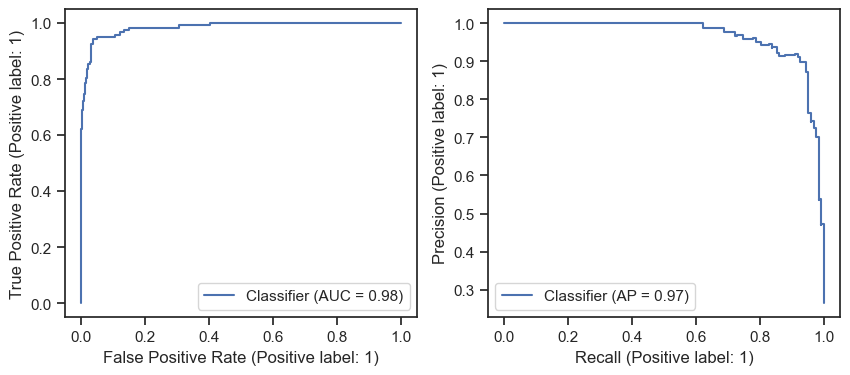

In [8]:
# Create our blank figure with 2 panels
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot the ROC and PR curves:
RocCurveDisplay.from_predictions(y_test, probs, ax=axs[0])
PrecisionRecallDisplay.from_predictions(y_test, probs, ax=axs[1])

# Display the plot:
plt.show()

**Homework:** How do our results compare to that presented in the paper?